In [270]:
import gym
import numpy as np

env = gym.make('CartPole-v0')
observation = env.reset()
def run(env, policy, rewarder=Rewarder(), render = False):
    reward = 0
    observation = env.reset()
    done = False
    count = 0
    observations = [observation]
    while(done == False):        
        action = policy.step(observation, reward)            
        observation, raw_reward, done, info = env.step(action)
        reward = rewarder.get_reward(observation, raw_reward, done, info, count)
        if(render):
            env.render()
        count += 1
        observations += [observation]
#         print(observation, reward, done, info)
    action = policy.step(observation, reward)  # step called to process the final reward
    return count, observations


In [251]:
class Policy(object):
    def step(self, observation, reward):
        return 0

In [249]:
class Rewarder(object):
    def get_reward(self, observation, raw_reward, done, info, count):
        return raw_reward

In [252]:
policy = Policy()
obs = np.vstack([np.vstack(run(env, policy)[1]) for i in range(100)] )

In [253]:
import pandas as pd
pd.DataFrame(obs).describe()

,0,1,2,3
count,1028.000000,1028.000000,1028.000000,1028.000000
mean,-0.049253,-0.910347,0.077599,1.406762
std,0.060814,0.587901,0.081231,0.921379
min,-0.221702,-2.156585,-0.049323,-0.048268
25%,-0.088829,-1.393988,0.013292,0.596620
50%,-0.041635,-0.936842,0.055567,1.418577
75%,-0.001722,-0.394724,0.135145,2.164119
max,0.050084,0.049283,0.269082,3.330385


In [284]:
class QLearningPolicy(Policy):
    def __init__(self, gamma = 0.9, lr = 0.3, epsilon = 0.2, box_size = 1, verbose = False):
        self.q = {}
        self.last_state_action=None
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.verbose = verbose
        self.box_size = box_size 
    
    def step(self, observation, reward):        
        weights = self.box_size * np.array([0.062775 ,0.593712,0.082334,0.928363])  # std for each dimension
        normalized = observation / weights
        floored = np.floor(normalized)
        s = str(floored)
        
        self.update(reward, s)
        
        a = 0 if self.evaluate(s+str(0)) > self.evaluate(s+str(1)) else 1
        if np.random.rand() < self.epsilon:
            a = np.random.choice([0,1])
        
        self.last_state_action = s+str(a)
        return a
    
    def evaluate(self, key):        
        if key not in self.q:
            self.q[key] = 0
        return self.q[key]
    
    def update(self, reward, s):
        lr = self.lr
        if self.last_state_action is None:
            return
        old = self.q[self.last_state_action]
        new = reward + self.gamma * max([self.evaluate(s+str(a)) for a in [0,1]])        
        self.q[self.last_state_action] = lr * new + (1-lr) * old
        if self.verbose:
            print(reward)



In [295]:
class RewardAtEndRewarder(Rewarder):
    def __init__(self, verbose = False):
        self.verbose = verbose
        
    def get_reward(self, observation, raw_reward, done, info, count):
        if count < 200 and done:
            if self.verbose:
                print('Fallen over -> punish (-100)')
            return -100        
        return 0


100% (10000 of 10000) |##################| Elapsed Time: 0:02:27 Time:  0:02:27


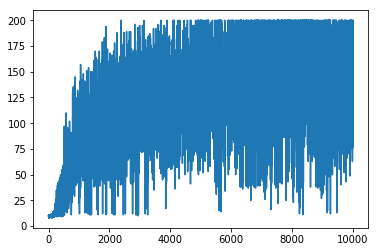

In [286]:
from progressbar import progressbar
p = QLearningPolicy(lr=1, epsilon=0, box_size=0.5)
r = RewardAtEndRewarder()
results = [run(env, p, rewarder=r)[0] for i in progressbar(range(10000))]
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(results)

In [296]:
# p.verbose = True
r.verbose = True
run(env, p, rewarder=r, render=True)

(155,
 [array([ 0.0456706 ,  0.01400351, -0.00746109,  0.00186667]),
  array([ 0.04595067,  0.20923167, -0.00742376, -0.29316096]),
  array([ 0.0501353 ,  0.40445867, -0.01328698, -0.58817596]),
  array([ 0.05822448,  0.20952529, -0.0250505 , -0.29970795]),
  array([ 0.06241498,  0.40499518, -0.03104466, -0.60018488]),
  array([ 0.07051489,  0.21032098, -0.04304836, -0.31743995]),
  array([ 0.07472131,  0.01583777, -0.04939715, -0.0386377 ]),
  array([ 0.07503806, -0.1785423 , -0.05016991,  0.23805989]),
  array([ 0.07146721,  0.01725915, -0.04540871, -0.0700165 ]),
  array([ 0.0718124 , -0.17718337, -0.04680904,  0.20800106]),
  array([ 0.06826873,  0.01857558, -0.04264902, -0.09907256]),
  array([ 0.06864024, -0.17591001, -0.04463047,  0.17985553]),
  array([ 0.06512204,  0.01982124, -0.04103336, -0.126566  ]),
  array([ 0.06551847,  0.21550628, -0.04356468, -0.43190689]),
  array([ 0.06982859,  0.02102738, -0.05220282, -0.15326929]),
  array([ 0.07024914, -0.17330974, -0.0552682 ,  

In [ ]:
p.verbose = False
r.verbose = False

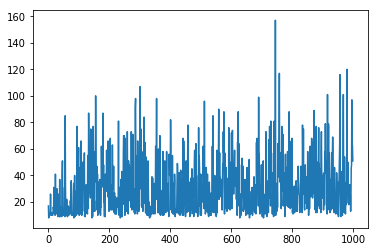

In [224]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(results)